In [23]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
batch_size_train = 64

In [7]:
batch_size_test = 500
transform = transforms.Compose([
    transforms.ToTensor(), # Transform to tensor, so scale data to [0.1] range
    transforms.Normalize((0.1307,),(0.3081,)) # Scale to have zero mean and standard deviation. Values of mean and STD taken as given.
])

In [5]:
# Load train data
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=True, download=True, 
                                                                      transform=transform),
                                                                      batch_size=batch_size_train, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 241kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.21MB/s]


In [9]:
# Load test data
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=False, download=True, 
                                                                      transform=transform),
                                                                      batch_size=batch_size_test, shuffle=True)

In [ ]:
# Get a batch of the test data. Shape shold be %batch_size_test, 1, 28, 28
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [21]:
example_data.shape

torch.Size([500, 1, 28, 28])

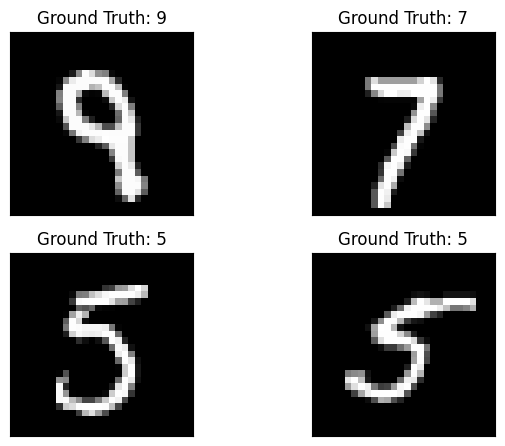

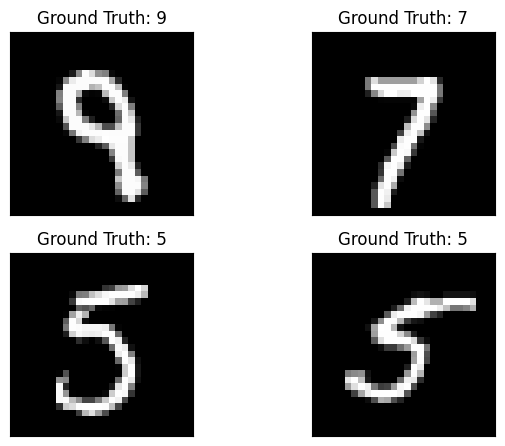

In [22]:
# Print examples of the handwritten digits and the targets (ground truth)
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
class DigitClassifier(nn.Module):
    
    def __init__(self) -> None:
        super(DigitClassifier, self).__init__()

        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))

        return F.log_softmax(x)

